# ゲノム解析

量子アニーリング方式によるアセンブリング

<hr>

IBM Community Japan　ナレッジモール研究  
量子コンピューターの活用研究 －機械学習・量子化学計算・組み合わせ最適化への応用－

In [ ]:
# GoogleDrive上のモジュール配置パス（DeBruijnDNA.py、phi-x.600l.gfa などがあるフォルダまでのパス）
FILE_PATH = '/gdrive/My Drive/Genom/'

In [ ]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
# GoogleDrive上にあるモジュールのパスを通す
import sys
sys.path.append(FILE_PATH)

In [ ]:
# D-WaveのSDKをインストール
!pip install dwave-ocean-sdk

In [ ]:
# グラフ分割ソフト：https://github.com/inducer/pymetis
!pip install PyMetis

In [ ]:
import re
import itertools

import matplotlib.pyplot as plt

# Numpy
import numpy as np

# グラフ可視化ライブラリ：https://graphviz.org/
from graphviz import Digraph

# ネットワーク構造解析のライブラリ：https://networkx.org/
import networkx as nx
import networkx.algorithms as nxa

# グラフ分割
import pymetis

# D-Wave
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import LeapHybridSampler

import DeBruijnDNA
import AcyclicGraphDNA

import matplotlib.pyplot as plt

# API_KEY = "D-WAVE_OCEAN_SDK_API_KEY" #API_KEY, register on https://www.dwavesys.com/take-leap # シュミレータを使用するため、記載を削除

In [ ]:
#def solve_dwave(Q, API_KEY):         # APIキーを利用しないシュミレータで実装するため、記載を削除しています。
def solve_dwave(Q):
    """
    Q = np.array([[-1, 1, 0], [1, -1, -2], [0, -2, -1]])
    solve_dwave(Q)
    """
    q = {}
    size = len(Q)
    for i in range(size):
        for j in range(size):
            q[(i,j)] = Q[i][j]

    # シミュレータでの実装に書き換えています
    #sampler = LeapHybridSampler(token=API_KEY)
    #response = sampler.sample_qubo(q, num_reads=30, anneal_time=20)
    solver = dimod.IdentitySampler()
    response = solver.sample_qubo(q, num_reads=30, anneal_time=20)

    result = []
    for sample, energy in response.data(['sample', 'energy']): 
        result.append(sample)
        result.append(energy)

    result.append(response.info) # view timings
    
    return result

## 1. Hamiltonian path De Bruijn graph

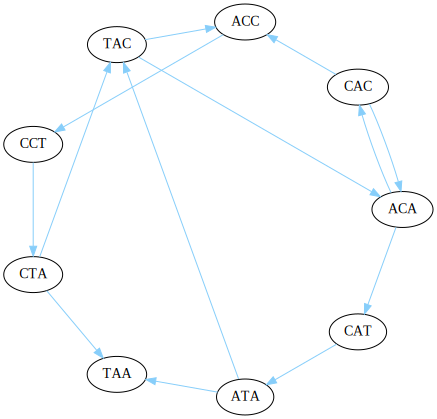

In [ ]:
#ツール読み込み
import dimod

seq = 'CATACACCTAA'                                                                         # シーケンスの定義
kmer_len, suffix_len = 3, 2                                                                 # 塩基の長さと、結合する際の共通する塩基の個数
adj, node_labels = DeBruijnDNA.make_debr(seq, kmer_len=kmer_len, suffix_len=suffix_len)     # De Brujin graphの作成

g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, [], kmer_len = kmer_len)                # グラフ描画のためのデータ準備
g.engine = 'circo'                                                                          # Graphvizの円形グラフで描画。Graphvizはdot言語で記述されたグラフ構造を任意のフォーマットの画像ファイルへ出力するツールです。
Q = DeBruijnDNA.to_qubo(adj)                                                                # 隣接行列をQUBOに変換

g                                                                                           # グラフ描画

/usr/local/lib/python3.7/dist-packages/dimod/core/sampler.py:291: SamplerUnknownArgWarning: Ignoring unknown kwarg: 'anneal_time'
  return self.sample(bqm, **parameters)


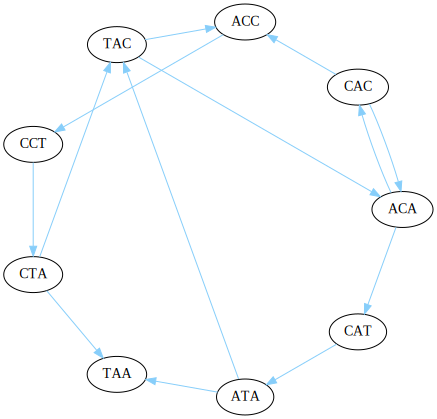

In [ ]:
target_energy = -np.sqrt(len(Q))                                                            # QUBOの長さをもとにnumpy配列の平方根を計算、DeBrujinDNAでは使用しない。
# solution = solve_dwave(Q, API_KEY=API_KEY)                                                
solution = solve_dwave(Q)                                                                   # D-Waveによる処理
spins, energy = [solution[0][i] for i in solution[0].keys()], solution[1]                   # グラフ描画のためのデータ準備

g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, path_spins=spins, kmer_len=kmer_len)    # グラフの描画
g.engine = 'circo'
g